### 人脸对齐

#### SSIM度量
结构相似性指数（Structural Similarity Index，SSIM）：综合考虑亮度、对比度和结构信息，可以评估两张图片的相似性。值范围在[-1, 1]之间，接近1表示相似度较高。


In [16]:
import numpy as np
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity
import pandas as pd
from pathlib import Path
def calculate_ssim(image1:Image.Image, image2:Image.Image):
    # 将图像对象转换为NumPy数组
    array1 = np.array(image1)
    array2 = np.array(image2)

    # 将图像转换为灰度图像（如果图像不是灰度图像）
    if len(array1.shape) > 2:
        array1 = np.mean(array1, axis=2)
    if len(array2.shape) > 2:
        array2 = np.mean(array2, axis=2)

    # 计算SSIM相似度
    ssim = structural_similarity(array1, array2)

    return ssim

def get_video_from_doc(data_path,data_info,standard_df):
    doc=standard_df
    video_path=Path()/ data_path/doc.unique_path
    for path,onset,offset,clip_id in zip(video_path,doc.start_frame,doc.end_frame,doc.unique_path):
        t=[]
        for i in range(onset,offset+1):
            img_path=path/data_info.imagefile_template.format(i)
            t.append(Image.open(img_path))
        yield video_path,tuple(t),clip_id

from data.clean_doc import build_cleaned_doc
from data.base import SMICHSE_info
data_info=SMICHSE_info()
doc=build_cleaned_doc(data_info.name,data_info.doc_path)
align_data_path="/home/neu-wang/mby/mer/reference_lib/temp/smic-hs-e/openface_align" 
align_data_path='/home/neu-wang/mby/database/SMIC-E-HS/dlib_crop_twice' # 0.80
align_data_path='/home/neu-wang/mby/database/SMIC-E-HS/aligned_dlib_crop_twice' #0.83
res={'ssim':[]}
for video_path,imgs,clip_id in get_video_from_doc(align_data_path,data_info,doc):
    ref_img=imgs[0]
    t={'ssim':[]}
    for img in imgs[1:]:
        # 计算SSIM相似度
        ssim_score = calculate_ssim(ref_img, img)
        t['ssim'].append(ssim_score)
    res['ssim'].append(sum(t['ssim'])/len(t['ssim']))
res=pd.DataFrame(res)
res.describe()

,ssim
count,166.000000
mean,0.832800
std,0.080929
min,0.269544
25%,0.826030
50%,0.853116
75%,0.874855
max,0.899519


In [6]:
import numpy as np
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity
import pandas as pd
from pathlib import Path
def calculate_ssim(image1:Image.Image, image2:Image.Image):
    # 将图像对象转换为NumPy数组
    array1 = np.array(image1)
    array2 = np.array(image2)

    # 将图像转换为灰度图像（如果图像不是灰度图像）
    if len(array1.shape) > 2:
        array1 = np.mean(array1, axis=2)
    if len(array2.shape) > 2:
        array2 = np.mean(array2, axis=2)

    # 计算SSIM相似度
    ssim = structural_similarity(array1, array2)

    return ssim

from data.clean_doc import build_cleaned_doc
from data.base import SMICHSE_info
data_info=SMICHSE_info()
doc=build_cleaned_doc(data_info.name,data_info.doc_path)
# 计算SSIM相似度
# align_data_path="/home/neu-wang/mby/mer/reference_lib/temp/smic-hs-e/openface_align"
align_data_path=data_info.raw_data_path
# video_path=Path(align_data_path)/doc.unique_path
video_path=Path(align_data_path)/doc.path
res=[]
for path,onset,offset,clip_id in zip(video_path,doc.start_frame,doc.end_frame,doc.unique_path):
    ref_img_path=path/data_info.imagefile_template.format(onset)
    ref_img=Image.open(ref_img_path)
    t=[]
    for i in range(onset,offset+1):
        img_path=path/data_info.imagefile_template.format(i)
        ssim_score = calculate_ssim(ref_img, Image.open(img_path))
        t.append(ssim_score)
    res.append(sum(t)/len(t))
res=pd.Series(res)
res.describe()

count    166.000000
mean       0.596146
std        0.052179
min        0.364734
25%        0.569046
50%        0.600923
75%        0.639528
max        0.678395
dtype: float64

### offline data augmentation

In [2]:
from pathlib import Path
anno='/home/neu-wang/mby/database/CASME2/uqi_3classes-5folds-annotations'
annotation_path = Path(anno)
assert annotation_path.exists() and annotation_path.is_dir()

train_annotation_list = list(annotation_path.glob("fold*_train.txt"))
val_annotation_list = list(annotation_path.glob("fold*_test.txt"))
assert len(train_annotation_list) == len(val_annotation_list)

for i in range(0,len(train_annotation_list)):
    train_annotation_file = annotation_path / "fold{}_train.txt".format(i)

    val_annotation_file = annotation_path / "fold{}_test.txt".format(i)
    break

train_annotation_file

PosixPath('/home/neu-wang/mby/database/CASME2/uqi_3classes-5folds-annotations/fold0_train.txt')

In [3]:
import pandas as pd
orign_df=pd.read_csv(train_annotation_file,sep=' ',header=None)


In [4]:
derived_df1=orign_df.copy()
derived_df1[3]=derived_df1[2]
derived_df1

,0,1,2,3,4
0,sub01/EP02_01f/46_86,46,59,59,1
1,sub01/EP19_05f/396_446,396,416,416,2
2,sub01/EP19_06f/36_161,36,71,71,2
3,sub02/EP01_11f/46_96,46,91,91,2
4,sub02/EP02_04f/31_141,31,79,79,2
...,...,...,...,...,...
113,sub26/EP18_44/11_71,11,36,36,2
114,sub26/EP18_47/6_86,6,49,49,2
115,sub26/EP18_49/16_80,16,54,54,2
116,sub26/EP18_50/78_161,78,99,99,2


In [5]:

derived_df2=orign_df.copy()
derived_df2[1]=derived_df2[2]
derived_df2

,0,1,2,3,4
0,sub01/EP02_01f/46_86,59,59,86,1
1,sub01/EP19_05f/396_446,416,416,446,2
2,sub01/EP19_06f/36_161,71,71,161,2
3,sub02/EP01_11f/46_96,91,91,96,2
4,sub02/EP02_04f/31_141,79,79,141,2
...,...,...,...,...,...
113,sub26/EP18_44/11_71,36,36,71,2
114,sub26/EP18_47/6_86,49,49,86,2
115,sub26/EP18_49/16_80,54,54,80,2
116,sub26/EP18_50/78_161,99,99,161,2


In [6]:
aug_df=pd.concat([orign_df,derived_df1,derived_df2],ignore_index=True)
aug_df

,0,1,2,3,4
0,sub01/EP02_01f/46_86,46,59,86,1
1,sub01/EP19_05f/396_446,396,416,446,2
2,sub01/EP19_06f/36_161,36,71,161,2
3,sub02/EP01_11f/46_96,46,91,96,2
4,sub02/EP02_04f/31_141,31,79,141,2
...,...,...,...,...,...
349,sub26/EP18_44/11_71,36,36,71,2
350,sub26/EP18_47/6_86,49,49,86,2
351,sub26/EP18_49/16_80,54,54,80,2
352,sub26/EP18_50/78_161,99,99,161,2


In [7]:
name=Path(train_annotation_file).name.split('_')
name.insert(1,'offline_aug')
name='_'.join(name)
aug_df.to_csv(Path(train_annotation_file).parent/name,header=False,index=False)

In [ ]:
def generate_offline_aug_train_anno(train_annotation_file):
    import pandas as pd
    orign_df=pd.read_csv(train_annotation_file,sep=' ',header=None)
    derived_df1=orign_df.copy()
    derived_df1[3]=derived_df1[2]
    # derived_df1
    derived_df2=orign_df.copy()
    derived_df2[1]=derived_df2[2]
    # derived_df2
    aug_df=pd.concat([orign_df,derived_df1,derived_df2],ignore_index=True)
    # aug_df
    name=Path(train_annotation_file).name.split('_')
    name.insert(1,'offline_aug')
    name='_'.join(name)
    aug_df.to_csv(Path(train_annotation_file).parent/name,header=False,index=False)



### 可视化预处理

#### 人脸剪裁

[(-12, 84), (-12, 118), (-9, 153), (-5, 189), (1, 224), (20, 255), (49, 277), (82, 294), (120, 298), (158, 295), (193, 279), (225, 259), (248, 233), (256, 197), (259, 161), (261, 126), (263, 92), (1, 51), (19, 32), (47, 28), (76, 31), (103, 40), (153, 39), (180, 31), (207, 28), (234, 33), (250, 51), (129, 74), (129, 98), (129, 121), (130, 146), (94, 168), (111, 171), (128, 173), (144, 171), (159, 169), (24, 81), (43, 77), (62, 76), (82, 83), (63, 87), (43, 87), (171, 83), (190, 76), (209, 78), (228, 82), (210, 87), (191, 87), (68, 221), (89, 206), (111, 196), (125, 201), (141, 197), (162, 208), (182, 221), (162, 235), (141, 241), (124, 243), (108, 242), (87, 235), (78, 220), (110, 214), (125, 216), (141, 215), (173, 221), (141, 216), (125, 218), (109, 216)]


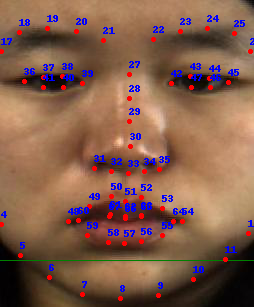

In [20]:
from PIL import Image
from merlib.preprocess.utils.visual_tool import visualize_dlib_bbox
import dlib
from imutils import face_utils
import cv2 as cv
import numpy as np
from PIL import Image
from merlib.data import DLIB_FACE_LANDMARK_PATH
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(str(DLIB_FACE_LANDMARK_PATH))
import openface
align = openface.AlignDlib(DLIB_FACE_LANDMARK_PATH)

def get_landmarks(img:np.ndarray):
    face_rects = detector(img, 0)
    for index, face in enumerate(face_rects):
        print(index)
        shape = predictor(img, face_rects[index])
        print('-----------------',shape)
        shape = face_utils.shape_to_np(shape)
        # for (x, y) in shape:
        #     cv.circle(img, (x, y), 1, (0, 0, 255), -1)
        return shape
img_path='/home/neu-wang/mby/mer/reference_lib/merlib/datasets/samples/casme2_unpreprocessed.jpg'
img_path="/home/neu-wang/mby/mer/reference_lib/merlib/datasets/samples/casme2_cropped_origin.jpg"
img_path='/home/neu-wang/mby/mer/reference_lib/temp/casme2/openface_align/sub01/EP02_01f/46_86/img46.jpg'
img_path='/home/neu-wang/mby/mer/reference_lib/temp/casme2/openface_align/sub26/EP09_09/46_101/img46.jpg'
img_path='/home/neu-wang/mby/database/CASME2/Cropped/sub07/EP06_01/img15.jpg'
img=Image.open(img_path)
np_img=np.array(img)
# landmarks=get_landmarks(np_img)
face_bb=align.getLargestFaceBoundingBox(np_img)
landmarks=align.findLandmarks(np_img,face_bb)
visualize_dlib_bbox(img,show_landmarks=True,show_vis=False,show_bbox=True,names=range(68))

In [22]:
from merlib.preprocess.utils.dlib_crop_face import dlib_crop_more_ROI
img.crop(dlib_crop_more_ROI(img))

AssertionError: None

#### 人脸配准


In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = "tight"
# sphinx_gallery_thumbnail_number = 2


def plot_ndarray_and_PILImage(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            # img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

/home/neu-wang/mby/anaconda3/envs/pl/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


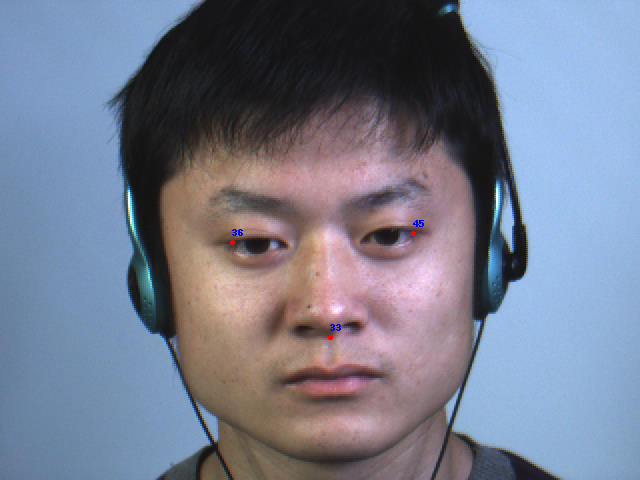

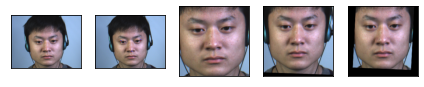

In [2]:
from PIL import Image
img_path='/home/neu-wang/mby/mer/reference_lib/datasets/samples/casme2_unpreprocessed.jpg'
# img_path='/home/neu-wang/mby/database/SMIC-E-HS/openface_align/s01/s1_ne_01/559740_559775/image559740.jpg'
img=Image.open(img_path)
from preprocess.utils.openface_align_face import align_face_by_openface,get_simple_square_face
from preprocess.utils.visual_tool import visualize_dlib_bbox
imgs=[]
imgs.append(img)

imgs.append(visualize_dlib_bbox(img.copy(),landmarks_indexes=[36,45,33],names=[36,45,33],show_bbox=False))
crop_img=get_simple_square_face([np.array(img)],0)[0]
imgs.append(crop_img)

landmarkIndices=None
align_img=align_face_by_openface([img],resize=256, landmarkIndices=landmarkIndices)[0]
imgs.append(align_img)
align_img2=align_face_by_openface([Image.fromarray(crop_img) ],landmarkIndices=landmarkIndices)[0]
imgs.append(align_img2)
plot_ndarray_and_PILImage(imgs)

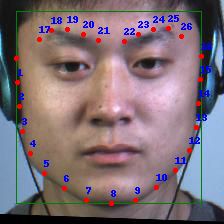

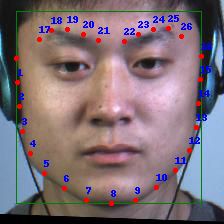

In [15]:
from PIL import Image, ImageDraw
from typing import Tuple,Union
import dlib
import numpy as np
from data import DLIB_FACE_LANDMARK_PATH
from preprocess.utils.visual_tool import rect_to_tuple,dlib_landmarks2tuple,visualize_bbox_landmarks
path='/home/neu-wang/mby/mer/reference_lib/datasets/samples/align_img46.jpg'
img=Image.open(path)
detector = dlib.get_frontal_face_detector()
rects = detector(np.array(img), 1)
bbox=rect_to_tuple(rects[0])
predictor = dlib.shape_predictor(DLIB_FACE_LANDMARK_PATH)
landmarks = predictor(np.array(img), rects[0])
landmarks=dlib_landmarks2tuple(landmarks)
landmarks=np.array(landmarks)
landmarks2=np.array(landmarks)[0:27]
x_min = np.min(landmarks[:, 0])
x_max = np.max(landmarks[:, 0])
y_min = np.min(landmarks[:, 1])
y_max = np.max(landmarks[:, 1])
ys=landmarks[:, 1]
bbox2=[x_min,y_min-(ys[36]-ys[18])//2,x_max,y_max]
visualize_bbox_landmarks(img,bbox2,tuple(landmarks2),show_vis=True,names=range(len(landmarks2)))

In [16]:
x=_

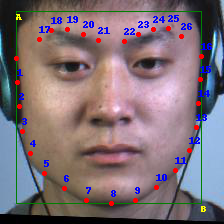

In [17]:
draw = ImageDraw.Draw(x)
A=(x_min,y_min-(ys[36]-ys[18])//2)
B=(x_max,y_max)
draw.text(A, str('A'), fill='yellow',font_size=12)
draw.text(B, str('B'), fill='yellow',font_size=12)
x

In [4]:
img=Image.open('/home/neu-wang/mby/mer/reference_lib/preprocess/temp/casme2/sub10/EP08_01f/76_141/img77.jpg')
visualize_dlib_bbox(img,show_vis=False)

FileNotFoundError: [Errno 2] No such file or directory: '/home/neu-wang/mby/mer/reference_lib/preprocess/temp/casme2/sub10/EP08_01f/76_141/img77.jpg'

#### 人脸剪裁

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = "tight"
# sphinx_gallery_thumbnail_number = 2


def plot_ndarray_and_PILImage(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            # img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

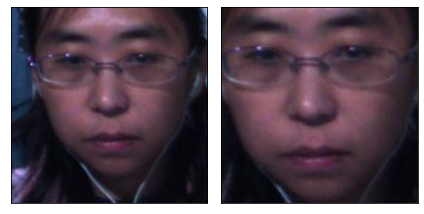

In [4]:
from PIL import Image
# img_path='/home/neu-wang/mby/mer/reference_lib/preprocess/temp/casme2/sub02/EP01_11f/46_96/img46.jpg'
img=Image.open(img_path)
# from preprocess.utils.openface_align_face import align_face_by_openface,get_simple_square_face
# from preprocess.utils.visual_tool import visualize_dlib_bbox
from preprocess.utils.dlib_crop_face import dlib_crop_twice
imgs=[]
imgs.append(img)
crop_img=img.crop(dlib_crop_twice(img,times=1)) 
imgs.append(crop_img)
plot_ndarray_and_PILImage(imgs)

### Draft模型光流可视化

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = "tight"
# sphinx_gallery_thumbnail_number = 2


def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

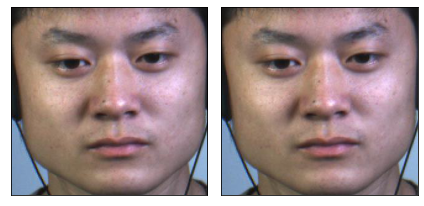

In [2]:
from torchvision.io import read_image
onset_img_path='/home/neu-wang/mby/mer/dual_flows/datasets/samples/casme2_cropped.jpg'
apex_img_path='/home/neu-wang/mby/mer/dual_flows/datasets/samples/casme2_crooped2.jpg'
onset_img=read_image(onset_img_path)
apex_img=read_image(apex_img_path)

plot([onset_img,apex_img])

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

from torchvision.models.optical_flow import raft_large
from torchvision.models.optical_flow import Raft_Large_Weights

weights = Raft_Large_Weights.DEFAULT
transforms = weights.transforms()


def preprocess(img1_batch, img2_batch):
    size=[224, 224]
    img1_batch = F.resize(img1_batch, size=size)
    img2_batch = F.resize(img2_batch, size=size)
    return transforms(img1_batch, img2_batch)

img1_batch = torch.stack([onset_img])
img2_batch = torch.stack([apex_img])

img1_batch, img2_batch = preprocess(img1_batch, img2_batch)

print(f"shape = {img1_batch.shape}, dtype = {img1_batch.dtype}")


# If you can, run this example on a GPU, it will be a lot faster.
device = "cuda" if torch.cuda.is_available() else "cpu"
device='cpu'
model = raft_large(weights=Raft_Large_Weights.DEFAULT, progress=False).to(device)
model = model.eval()

list_of_flows = model(img1_batch.to(device), img2_batch.to(device))
print(f"type = {type(list_of_flows)}")
print(f"length = {len(list_of_flows)} = number of iterations of the model")



shape = torch.Size([1, 3, 224, 224]), dtype = torch.float32
type = <class 'list'>
length = 12 = number of iterations of the model


dtype = torch.float32
shape = torch.Size([1, 2, 224, 224]) = (N, 2, H, W)
min = -0.0872633308172226, max = 0.15845654904842377


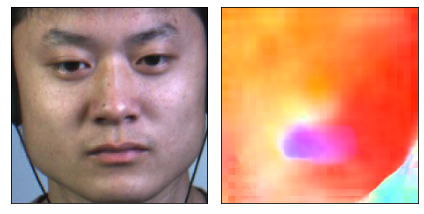

In [4]:
predicted_flows = list_of_flows[-1]
print(f"dtype = {predicted_flows.dtype}")
print(f"shape = {predicted_flows.shape} = (N, 2, H, W)")
print(f"min = {predicted_flows.min()}, max = {predicted_flows.max()}")

from torchvision.utils import flow_to_image

flow_imgs = flow_to_image(predicted_flows)

# The images have been mapped into [-1, 1] but for plotting we want them in [0, 1]
img1_batch = [(img1 + 1) / 2 for img1 in img1_batch]

grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_batch, flow_imgs)]
plot(grid)

In [12]:
from utils.optical_flow import getOFVideo

video= torch.stack([onset_img,apex_img])
print(video.shape)
flows=getOFVideo(video)
print(flows[:,:2].shape,flows[:,:2].dtype)

torch.Size([2, 3, 306, 319])
torch.Size([1, 2, 306, 319]) torch.uint8


### 可视化图片patches

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'
from torchvision.utils import make_grid

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.array(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

/home/neu-wang/mby/anaconda3/envs/pl/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


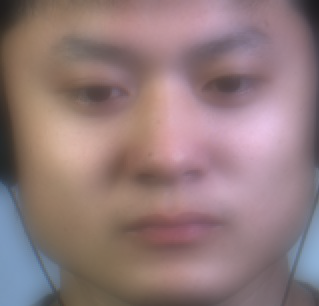

In [8]:
from PIL import Image, ImageFilter

# 读取图像
img_path='/home/neu-wang/mby/mer/dual_flows/datasets/samples/casme2_cropped.jpg'

image = Image.open(img_path)

# 创建一个大小相同的空白图像
blurred_image = Image.new('RGB', image.size)

# 应用高斯模糊滤镜
blurred_image.paste(image, (0, 0))
blurred_image = blurred_image.filter(ImageFilter.GaussianBlur(radius=10))

# 合并原始图像和朦胧图像
final_image = Image.blend(image, blurred_image, alpha=0.8)

# 显示结果图像
final_image.show()


torch.Size([49, 3, 32, 32])

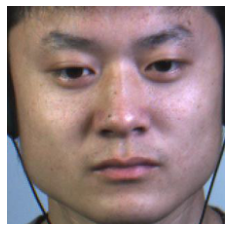

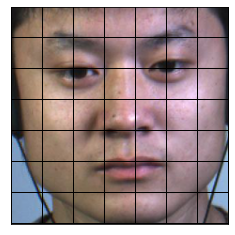

In [30]:
import matplotlib.font_manager as fm

font_list = fm.findSystemFonts()
for font_path in font_list:
    print(font_path)


/usr/share/fonts/truetype/dejavu/DejaVuSansMono.ttf
/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf
/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf
/usr/share/fonts/truetype/dejavu/DejaVuSansMono-Bold.ttf
/usr/share/fonts/truetype/dejavu/DejaVuSerif.ttf
/usr/share/fonts/truetype/dejavu/DejaVuSerif-Bold.ttf


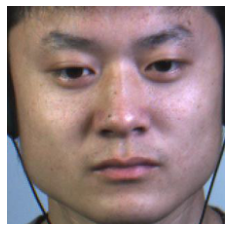

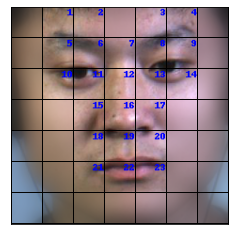

In [50]:
import sys 
sys.path.append('/home/neu-wang/mby/mer')
from pathlib import Path
import numpy as np
from PIL import Image,ImageFont,ImageDraw
import torchvision.transforms as transforms
from merlib.others.patchify import patchify, unpatchify
img_path='/home/neu-wang/mby/mer/dual_flows/datasets/samples/casme2_cropped.jpg'
# img_path= '/home/neu-wang/mby/database/SMIC-HS/s1/micro/negative/s1_ne_01/reg_image559743.bmp'
img_size=(224,224)
patch_size=(32,32,3)
image = np.array(Image.open(img_path).resize(img_size))
patches = patchify(image, patch_size, step=patch_size[0]) # split image into 2*3 small 2*2 patches.
reconstructed_image = unpatchify(patches, image.shape)
assert (reconstructed_image == image).all()

original_img=Image.fromarray(image) 
a=patches.reshape(-1,*patch_size)
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.imshow(original_img)
imgs=torch.tensor(a).permute(0,3,1,2)
# 创建一个大小相同的空白图像

imgs=[transforms.ToPILImage()(x) for x in imgs]
imgs[0].size
tx=1

blurred_image = Image.new('RGB', imgs[0].size)
for i,image in  enumerate(imgs):

    temp=[1,2,4,5, 8,9,10,11,12, 15,16,17,18,19, 23,24,25, 30,31,32, 37,38,39]
    if i in temp:
        # 创建绘图对象
        draw = ImageDraw.Draw(image)

        # 设置要添加的数字和字体样式
        number = tx
        tx+=1
        font_size = 1
        font = ImageFont.truetype('/usr/share/fonts/truetype/dejavu/DejaVuSerif.ttf', font_size)
        color = (255, 0, 0)  # 红色

        # 获取文本框的大小
        text_size = draw.textsize(str(number))

        # 计算文本框的位置
        x = image.width - text_size[0] - 0  # x坐标为图片宽度减去文本框宽度再减去一些边距
        y = 0  # y坐标为一些边距

        # 在图片上添加文本
        draw.text((x, y), str(number), fill='blue')
    if i not in temp:
        # 应用高斯模糊滤镜
        blurred_image.paste(image, (0, 0))
        blurred_image = blurred_image.filter(ImageFilter.GaussianBlur(radius=10))

        # 合并原始图像和朦胧图像
        final_image = Image.blend(image, blurred_image, alpha=0.9)
        imgs[i]=final_image
imgs=[transforms.ToTensor()(x) for x in imgs]
show( make_grid(imgs,nrow=img_size[0]//patch_size[0] ,padding=1)) 

In [4]:
torch.tensor(a).shape

torch.Size([49, 32, 32, 3])

### 可视化Transform

In [31]:
from datasets.utils.me_video_dataset import VideoFrameDataset,ImglistToTensor
from datasets.transforms import get_me_transform
import matplotlib.pyplot as plt

# data_root = "/home/neu-wang/mby/database/CASME2/dlib_crop_twice" # Folder in which all videos lie in a specific structure
data_root ='/home/neu-wang/mby/database/SAMM/dlib_crop_twice'
# annotation_file = "/home/neu-wang/mby/database/CASME2/unsupervised-annotations.txt" # A row for each video sample as: (VIDEO_PATH START_FRAME END_FRAME CLASS_ID)
# annotation_file = '/home/neu-wang/mby/mer/dual_flows/annotations/casme2/uni3classes-loso-annotations/fold20_train.txt'
annotation_file='/home/neu-wang/mby/mer/dual_flows/annotations/samm/uni3classes-loso-annotations/fold27_train.txt'
train_transform=get_me_transform(224,False,16,False,'FixSequenceInterpolation',scale=(0.8,1),registration_method=None)
all_dataset1 = VideoFrameDataset(
    root_path=data_root,
    annotationfile_path=annotation_file,
    num_segments=16,
    frames_per_segment=1,
    imagefile_template='{}.jpg',
    transform= None,
    sampling_strategy=0,
    test_mode=False
)


frames,label = all_dataset1[1]  # take first sample of dataset 
frames.shape

data sanity check successfully!


torch.Size([77, 3, 360, 367])

In [37]:
def measure_read(dataset):
    import time
    # 开始计时
    start_time = time.time()

    # 遍历数据加载器，读取数据
    for x in dataset:
        # 在这里可以根据需要进行额外的处理
        pass

    # 结束计时
    end_time = time.time()

    # 计算读取速度（样本/秒）
    total_samples = len(dataset)
    processing_time = end_time - start_time
    samples_per_second = total_samples / processing_time
    second_per_sample =processing_time/total_samples 
    print(f"数据集{str(dataset)}读取速度：{samples_per_second:.2f} 样本/秒 {second_per_sample:.2f} 秒/样本")
measure_read(all_dataset1)

数据集<datasets.utils.me_video_dataset.VideoFrameDataset object at 0x7f626fc4bfd0>读取速度：4.51 样本/秒 0.22 秒/样本


In [33]:
import torch
import torch.nn.functional as F
from einops import asnumpy, rearrange
class FixSequenceInterpolation:
    def __init__(self, sequence_length: int) -> None:
        self.sequence_length = sequence_length

    def __call__(self, x) -> None:
        """
        Arrgs:
            x(torch.ByteTensor): shape is (S, C, H, W)
        Return:
            torch byte tensor of desired length's video. Shape is (S_desired, C, H, W)
        """
        with torch.no_grad():
            s, _, h, w = x.shape
            if s == self.sequence_length:
                return x
            else:
                x = x.float()
                x = rearrange(x, "s c h w -> 1 c s h w")
                x = F.interpolate(
                    x, size=(self.sequence_length, h, w), mode="trilinear", align_corners=False
                )
                x = rearrange(x, "1 c s h w -> s c h w")
                # x = x.byte()
                return x

    def __str__(self):
        return str(self.sequence_length)


In [34]:
def measure_read_three_interplation(dataset):
    import time
    # 开始计时
    import torch.nn.functional as F
    start_time = time.time()
    
    # 遍历数据加载器，读取数据
    for x,_ in dataset:
        # 插值后的目标尺寸为16x3x224x224
        
        video=x[[0,x.shape[0]//2,x.shape[0]-1],:]
        # 将视频序列的空间尺寸插值为目标尺寸
        interpolated_video = FixSequenceInterpolation(16)(video)

        pass

    # 结束计时
    end_time = time.time()

    # 计算读取速度（样本/秒）
    total_samples = len(dataset)
    processing_time = end_time - start_time
    samples_per_second = total_samples / processing_time
    second_per_sample =processing_time/total_samples 
    print(f"数据集{str(dataset)}读取速度：{samples_per_second:.2f} 样本/秒 {second_per_sample:.2f} 秒/样本")
measure_read_three_interplation(all_dataset1)

数据集<datasets.utils.me_video_dataset.VideoFrameDataset object at 0x7f626fc4bfd0>读取速度：4.35 样本/秒 0.23 秒/样本


In [35]:
def measure_read_all_interplation(dataset):
    import time
    # 开始计时
    import torch.nn.functional as F
    start_time = time.time()
    
    # 遍历数据加载器，读取数据
    for x,_ in dataset:
        
        video=x
        # 将视频序列的空间尺寸插值为目标尺寸
        interpolated_video = FixSequenceInterpolation(16)(video)

        pass

    # 结束计时
    end_time = time.time()

    # 计算读取速度（样本/秒）
    total_samples = len(dataset)
    processing_time = end_time - start_time
    samples_per_second = total_samples / processing_time
    second_per_sample =processing_time/total_samples 
    print(f"数据集{str(dataset)}读取速度：{samples_per_second:.2f} 样本/秒 {second_per_sample:.2f} 秒/样本")
measure_read_all_interplation(all_dataset1)

数据集<datasets.utils.me_video_dataset.VideoFrameDataset object at 0x7f626fc4bfd0>读取速度：4.24 样本/秒 0.24 秒/样本


In [36]:
def measure_read_my_strategy(dataset):
    import time
    # 开始计时
    import torch.nn.functional as F
    start_time = time.time()
    
    # 遍历数据加载器，读取数据
    for x,_ in dataset:
        
        video=x
        # 将视频序列的空间尺寸插值为目标尺寸
        if video.shape[0]>=16:
            pass
        else:
            interpolated_video = FixSequenceInterpolation(16)(video)

        pass

    # 结束计时
    end_time = time.time()

    # 计算读取速度（样本/秒）
    total_samples = len(dataset)
    processing_time = end_time - start_time
    samples_per_second = total_samples / processing_time
    second_per_sample =processing_time/total_samples 
    print(f"数据集{str(dataset)}读取速度：{samples_per_second:.2f} 样本/秒 {second_per_sample:.2f} 秒/样本")
measure_read_my_strategy(all_dataset1)

数据集<datasets.utils.me_video_dataset.VideoFrameDataset object at 0x7f626fc4bfd0>读取速度：4.57 样本/秒 0.22 秒/样本


### DEMO 1 WITHOUT IMAGE TRANSFORMS

/home/neu-wang/mby/anaconda3/envs/pl/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


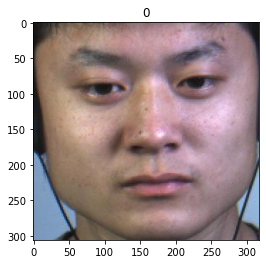

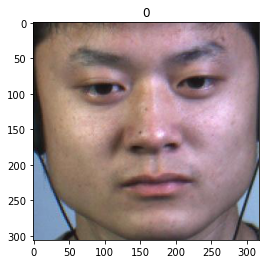

In [1]:
from pathlib import Path
from utils.video_dataset import VideoFrameDataset
import matplotlib.pyplot as plt
data_root = "/home/neu-wang/mby/database/CASME2/dlib_crop_twice2" # Folder in which all videos lie in a specific structure
annotation_file = "/home/neu-wang/mby/database/CASME2/unsupervised-annotations.txt" # A row for each video sample as: (VIDEO_PATH START_FRAME END_FRAME CLASS_ID)

""" DEMO 1 WITHOUT IMAGE TRANSFORMS """
dataset = VideoFrameDataset(
    root_path=data_root,
    annotationfile_path=annotation_file,
    num_segments=1,
    frames_per_segment=2,
    imagefile_template='img{}.jpg',
    transform=None,
    test_mode=False
)

frames,label = dataset[0]  # take first sample of dataset 
for image in frames:
    plt.imshow(image)
    plt.title(label)
    plt.show()
    plt.pause(1)

In [20]:
frames[0].size()

torch.Size([3, 224, 232])

### DEMO 2 WITH IMAGE TRANSFORMS

In [1]:
""" DEMO 2 WITH IMAGE TRANSFORMS """
from timm.data import create_transform
from utils.me_video_dataset import VideoFrameDataset,ImglistToTensor
from utils.autoaugment import AutoAugImageNetPolicy
from pytorchvideo.transforms import UniformTemporalSubsample

from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from torchvision import transforms as T
import torch
size=224

train_transform=T.Compose([ 
    ImglistToTensor(),
T.Resize(size, interpolation= T.InterpolationMode.BICUBIC),
T.RandomResizedCrop(size, scale=(0.8, 1)),
AutoAugImageNetPolicy(),
T.RandomHorizontalFlip(p=0.5),
T.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
        UniformTemporalSubsample(num_samples=10, temporal_dim=-4)

])   
test_transform=T.Compose([ 
    ImglistToTensor(),
T.Resize(size, interpolation= T.InterpolationMode.BICUBIC),
T.CenterCrop(size),
T.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
        UniformTemporalSubsample(num_samples=10, temporal_dim=-4)

])  
data_root = "/home/neu-wang/mby/database/CASME2/dlib_crop_twice" # Folder in which all videos lie in a specific structure
# annotation_file = "/home/neu-wang/mby/database/CASME2/unsupervised-annotations.txt" # A row for each video sample as: (VIDEO_PATH START_FRAME END_FRAME CLASS_ID)
annotation_file = '/home/neu-wang/mby/database/CASME2/uqi_3classes-5folds-annotations/fold0_test.txt'
dataset = VideoFrameDataset(
    root_path=data_root,
    annotationfile_path=annotation_file,
    num_segments=5,
    frames_per_segment=1,
    imagefile_template='img{}.jpg',
    transform= train_transform,
    data_mode=4,
    test_mode=False
)
def denormalize(video_tensor):
    """
    Undoes mean/standard deviation normalization, zero to one scaling,
    and channel rearrangement for a batch of images.
    args:
        video_tensor: a (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
    """
    inverse_normalize = T.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
    )
    return (inverse_normalize(video_tensor) * 255.).type(torch.uint8).permute(0, 2, 3, 1).numpy()

frames,label = dataset[0]  # take first sample of dataset 
# for image in denormalize(frames):
#     print(image.shape)
#     plt.imshow(image)
#     plt.title(label)
#     plt.show()
#     plt.pause(1)
frames

/home/neu-wang/mby/anaconda3/envs/pl/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


data sanity check successfully!
11
record path:/home/neu-wang/mby/database/CASME2/dlib_crop_twice/sub17/EP01_06/81_121,interval:(81, 121),label:1 can't be transformed successfully! len(images) 5


[<PIL.Image.Image image mode=RGB size=290x277 at 0x7F9C5455A040>,
 <PIL.Image.Image image mode=RGB size=290x277 at 0x7F9C5455A160>,
 <PIL.Image.Image image mode=RGB size=290x277 at 0x7F9C5455A280>,
 <PIL.Image.Image image mode=RGB size=290x277 at 0x7F9C5455A3A0>,
 <PIL.Image.Image image mode=RGB size=290x277 at 0x7F9C5455A4C0>]

### 以一张长宽比例更明显的图片变化

In [114]:

from torchvision import transforms as T
import torch
from PIL import Image
size=(224,224)
# size=224

train_transform=T.Compose([ 
T.Resize(size, interpolation= T.InterpolationMode.BICUBIC),
T.RandomResizedCrop(size, scale=(0.8, 1)),
# T.RandomHorizontalFlip(p=0.5)

])   
test_transform=T.Compose([ 
T.Resize(size, interpolation= T.InterpolationMode.BICUBIC),
T.CenterCrop(size)

])  

orignal size (w, h): (474, 718)


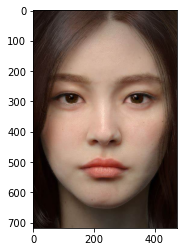

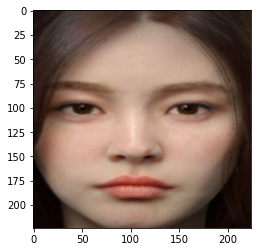

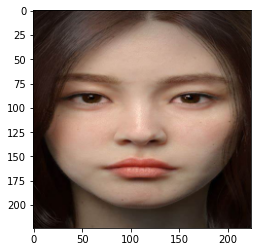

(<matplotlib.image.AxesImage at 0x7f8f803fd8b0>, None)

In [115]:
img=Image.open('face.jpg')
print('orignal size (w, h):',img.size)
train_img=train_transform(img)
# print(train_img.size)

test_img=test_transform(img)
import matplotlib.pyplot as plt
plt.imshow(img),plt.show()
plt.imshow(train_img),plt.show()
plt.imshow(test_img),plt.show()
